In [3]:
from dotenv import load_dotenv
import os
import pygsheets
import requests
import pandas as pd
from tqdm import tqdm

from pangres import upsert
from sqlalchemy import text, create_engine

load_dotenv()

True

In [4]:
db_username=os.environ.get("db_username")
db_password=os.environ.get("db_password")
db_host=os.environ.get("db_host")
db_port=os.environ.get("db_port")
# db_name=os.environ.get("db_name")
db_name = 'lol_analytics'


def create_db_connection_string(db_username: str, db_password: str, db_host: str, db_port: int, db_name: str):
    connection_url = f"postgresql+psycopg2://{db_username}:{db_password}@{db_host}:{db_port}/{db_name}"
    return connection_url

## Simple Analytics

In [5]:
connection_url = create_db_connection_string(db_username, db_password, db_host, db_port, db_name)
db_engine = create_engine(connection_url, pool_recycle=3600)
connection = db_engine.connect()

In [6]:
with db_engine.connect() as connection:
    df = pd.read_sql(text("SELECT * FROM soloq.player_matches"), connection)


In [7]:
df['lane'].unique()
df[df['username'] == 'RoboBoto']['team_position'].value_counts()

team_position
UTILITY    81
BOTTOM     15
JUNGLE      1
Name: count, dtype: int64

In [8]:
main_lane_games = df[(df['team_position'] == 'UTILITY') & (df['username'] == 'mazsu')]
main_lane_games['champion_name'].value_counts()

champion_name
Pyke         4
TahmKench    4
Poppy        3
Neeko        3
Braum        3
Pantheon     2
Morgana      1
Rell         1
Bard         1
Velkoz       1
Brand        1
Ornn         1
Rakan        1
Karma        1
Alistar      1
Thresh       1
Mel          1
Xerath       1
Name: count, dtype: int64

In [9]:
mains = main_lane_games['champion_name'].value_counts()[:3].reset_index()['champion_name'].tolist()

In [10]:
mains_only = main_lane_games[main_lane_games['champion_name'].isin(mains)]
mains_only['champion_name'].value_counts()

champion_name
TahmKench    4
Pyke         4
Poppy        3
Name: count, dtype: int64

In [11]:
summarized_stats = mains_only.groupby('champion_name')[['match_duration', 'champion_level','turret_kills', 'total_damage_dealt_to_champions', 'wards_killed','wards_placed', 'gold_earned', 'total_minions_killed', 'neutral_minions_killed', 'kills', 'deaths','assists', 'win']].mean()

summarized_stats['match_duration_in_minutes'] = summarized_stats['match_duration']/60
summarized_stats['cs_per_minute'] = (summarized_stats['total_minions_killed']+summarized_stats['neutral_minions_killed'])/summarized_stats['match_duration_in_minutes']
summarized_stats

,match_duration,champion_level,turret_kills,total_damage_dealt_to_champions,wards_killed,wards_placed,gold_earned,total_minions_killed,neutral_minions_killed,kills,deaths,assists,win,match_duration_in_minutes,cs_per_minute
champion_name,,,,,,,,,,,,,,,
Poppy,1843.00,14.333333,0.00,17674.666667,8.666667,31.333333,10529.666667,27.333333,0.666667,6.00,7.00,14.666667,0.666667,30.716667,0.911557
Pyke,1657.75,12.750000,0.00,16733.500000,13.500000,28.750000,10198.000000,36.000000,0.000000,8.75,7.25,9.750000,0.250000,27.629167,1.302971
TahmKench,1552.00,11.250000,0.25,9325.750000,4.500000,23.000000,7135.500000,23.500000,0.250000,1.50,5.50,10.500000,0.750000,25.866667,0.918170


## coordinates

In [12]:
connection_url = create_db_connection_string(db_username, db_password, db_host, db_port, db_name)
db_engine = create_engine(connection_url, pool_recycle=3600)
connection = db_engine.connect()

In [17]:
with db_engine.connect() as connection:
    matches_df = pd.read_sql(text("SELECT * FROM soloq.player_matches"), connection)


In [18]:
with db_engine.connect() as connection:
    match_timeline_df = pd.read_sql(text("SELECT * FROM soloq.player_matches_timeline"), connection)


In [124]:
current_player_puuid = matches_df[matches_df['username'] == 'oanduh']['puuid'].iloc[0]

matches_df = matches_df[(matches_df['username'] == 'oanduh') & (matches_df['team_position'] == 'MIDDLE')]

current_player_match_timeline_df = match_timeline_df[match_timeline_df['puuid'] == current_player_puuid].copy()

# Filter to only include matches that exist in the filtered matches_df
valid_match_ids = matches_df['match_id'].unique()
current_player_match_timeline_df = current_player_match_timeline_df[current_player_match_timeline_df['match_id'].isin(valid_match_ids)]

dict_of_matches_side = matches_df.set_index('match_id')['team_id'].to_dict()
current_player_match_timeline_df['side'] = current_player_match_timeline_df['match_id'].map(dict_of_matches_side)

# Filter for first minute of gameplay
current_player_match_timeline_df = current_player_match_timeline_df[current_player_match_timeline_df['timestamp'] < 2] 
one_minute_x_coord = current_player_match_timeline_df['x'].reset_index(drop=True)
one_minute_y_coord = current_player_match_timeline_df['y'].reset_index(drop=True)

In [125]:
one_minute_x_coord

0      14503
1       7906
2      14503
3       8525
4        557
       ...  
125     6253
126    14503
127     9265
128      557
129     5946
Name: x, Length: 130, dtype: int64

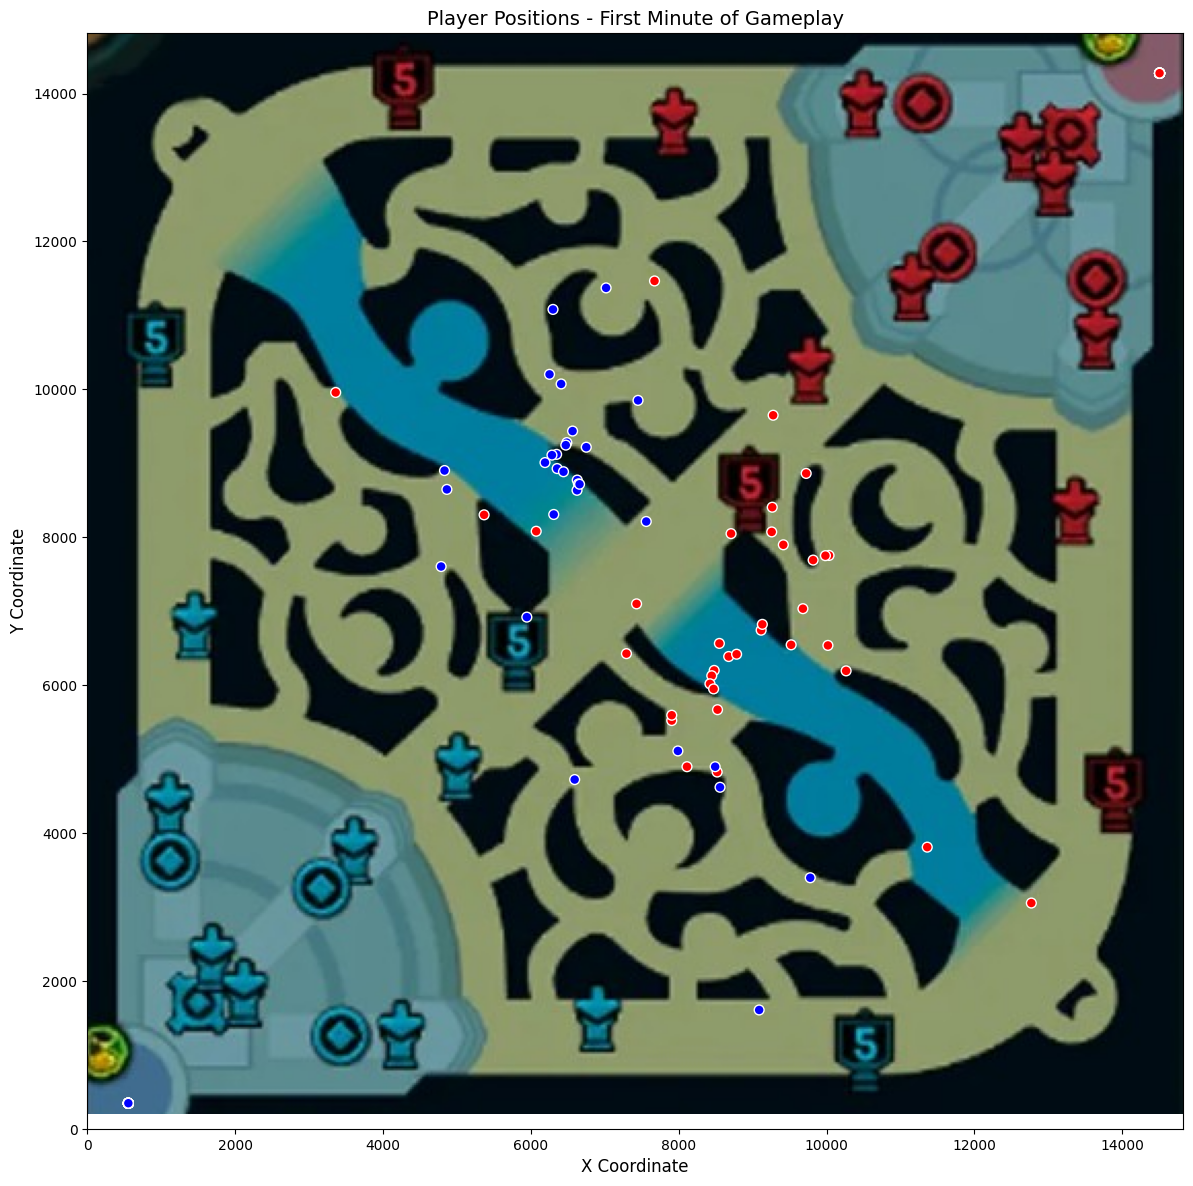

In [126]:
import matplotlib.pyplot as plt
from PIL import Image

# Load the League of Legends minimap image
image_path = 'League-of-Legends-Minimap.jpg'
img = Image.open(image_path)

# Create a figure with larger size for better visibility
fig, ax = plt.subplots(figsize=(12, 12))

# Display the image as background
# League of Legends map coordinates typically range from 0 to ~14820
# Set extent to match the game's coordinate system
# Adjust y_shift to move image up (positive) or down (negative)
y_shift = 200  # Adjust this value to move the image up/down
x_shift = 0
ax.imshow(img, extent=[x_shift, 14820 + x_shift, y_shift, 14820 + y_shift])

# Map team IDs to colors (100 = Blue side, 200 = Red side)
color_map = {'blue': 'blue', 'red': 'red'}
colors = [color_map[side] for side in current_player_match_timeline_df['side']]

# Plot the scatter points with better visibility
ax.scatter(one_minute_x_coord, one_minute_y_coord, c=colors, s=50, edgecolors='white', linewidths=1)

# Set labels and title
ax.set_xlabel('X Coordinate', fontsize=12)
ax.set_ylabel('Y Coordinate', fontsize=12)
ax.set_title('Player Positions - First Minute of Gameplay', fontsize=14)

# Set axis limits to match LoL map
ax.set_xlim(0, 14820)
ax.set_ylim(0, 14820)

plt.tight_layout()
plt.show()